# TODO

## 1. remove aupr from results -> ask Yaron about it 
## 2. remove frame from barplots
## 3. Add label to x in the barplots
## 4. Add barplots of 240 (250) vs. 500 (450)
## 5. Add barplots of validation results with the final features  -> ask Yaron if we need to show PRAUC 
## 6. Add barplots and graphs like in figure 4 in the paper



In [236]:
%reload_ext autoreload
%autoreload 2

In [237]:
import warnings
warnings.filterwarnings('ignore')

In [238]:
from IPython.core.display import display, HTML

# display wide notebook cells
display(HTML("<style>.container { width:100% !important; }</style>"))

In [239]:
import feature_importance
import feature_selection
import functools
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import train_and_predict
import util



from data import *
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline


# Read Data

In [240]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
path = Path('..\Data')

In [241]:
train_genomes_path = path / 'train_genomes.fasta'
train_genomes_metedata_path = path / 'train_genomes_info.csv'

test_genomes_path = path / 'test_genomes.fasta'
test_genomes_metedata_path = path / 'test_genomes_verified.csv'

train_dataset = GenomesData(train_genomes_path, train_genomes_metedata_path)
test_dataset = GenomesData(test_genomes_path, test_genomes_metedata_path)

Check split train dataset to train and validation according to insertion date

In [242]:
print('train dataset', len(train_dataset.data))

split = feature_selection.split_by_insertion_date(train_dataset, proportion=0.2)

train_idx, validation_idx = next(split.split())

X_train_raw, X_valid_raw = train_dataset.data[train_idx], train_dataset.data[validation_idx]
y_train, y_valid = train_dataset.y[train_idx], train_dataset.y[validation_idx]

print('train', len(X_train_raw), 'validation', len(X_valid_raw))

train dataset 641
train 513 validation 128


In [243]:
y_valid.value_counts()

1    89
0    39
Name: Label, dtype: int64

In [244]:
DATE_INSERTED = 'Date Inserted'

min_validation_date = min(train_dataset.metadata.iloc[validation_idx, :][DATE_INSERTED])
min_validation_date

Timestamp('2018-11-29 03:53:53.656000+0000', tz='UTC')

In [245]:
max_train_date = max(train_dataset.metadata.iloc[train_idx, :][DATE_INSERTED])
max_train_date

Timestamp('2018-11-29 03:08:47.637000+0000', tz='UTC')

In [246]:
assert min_validation_date > max_train_date

# Feature Selection - best k features according to chi2

## 20% validation

In [247]:
min_val = 50
max_val = 600
inc = 50

k_range = range(min_val, max_val + 1, inc)

split = feature_selection.split_by_insertion_date(train_dataset, proportion=0.2)
grid_search = feature_selection.perform_fs_k_best(train_dataset, k_range, split=split)
print(grid_search.best_params_)

param_name = 'k_best__k'
kvals_df = feature_selection.grid_search_results_to_df(grid_search, param_name)

Best roc_auc score is: 0.9030538749639873
{'k_best__k': 450}


In [268]:
def add_bar_labels(ax, round_by=2):
    for c, i in enumerate(ax.patches):
        height = round(i.get_height(), round_by)
        ax.annotate('{}'.format(round(i.get_height(), round_by)),
                   xy=(i.get_x() + i.get_width()/2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center', va='bottom', fontsize=12)

In [271]:
def create_fs_barplots(fs_df, width):
    fig, ax = plt.subplots(figsize=(10,6))
    fs_dict = dict(zip(list(fs_df.index), list(fs_df['mean_test_roc_auc'])))
    
    ax.set_xticks(list(fs_dict.keys()))
    ax.bar(*zip(*fs_dict.items()), width=width)
    ax.set_ylim([0.87, 0.905])
    ax.set_ylabel('AUROC',  fontsize=18)
    
    add_bar_labels(ax, 3)

Validation results per k value


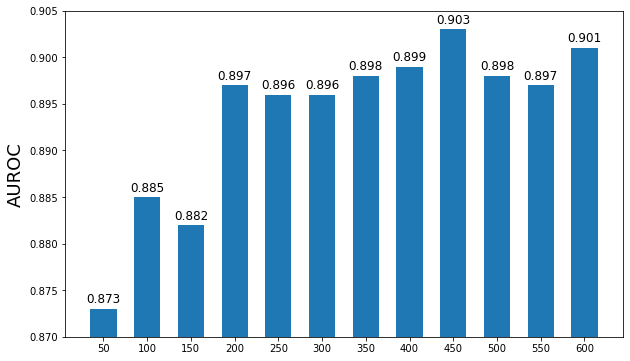

In [272]:
print('Validation results per k value')
create_fs_barplots(kvals_df, 30)

# Feature Selection - select best feature from each cluster

In [250]:
min_val = 0
max_val = 0.61
inc = 0.03
t_range = np.arange(min_val, max_val, inc)

# created corr matrix using feature_selection.create_corr_matrix(X_train_raw, y_train) 
corr_matrix_path = path / 'X_train_corr_mat_0.8_k450.csv'
corr_matrix_train = pd.read_csv(corr_matrix_path, index_col=0)
dist_matrix_train = feature_selection.feature_corr_to_dist_matrix(corr_matrix_train)

split = feature_selection.split_by_insertion_date(train_dataset, proportion=0.2)
grid_search_cluster = feature_selection.perform_fs_clusters(train_dataset, dist_matrix_train, t_range, split=split)
print(grid_search_cluster.best_params_)

param_name = 'cluster__threshold'
thresholds_df = feature_selection.grid_search_results_to_df(grid_search_cluster, param_name)

threshold=0.00, selected_features=450
threshold=0.03, selected_features=406
threshold=0.06, selected_features=373
threshold=0.09, selected_features=329
threshold=0.12, selected_features=298
threshold=0.15, selected_features=270
threshold=0.18, selected_features=244
threshold=0.21, selected_features=219
threshold=0.24, selected_features=201
threshold=0.27, selected_features=181
threshold=0.30, selected_features=159
threshold=0.33, selected_features=136
threshold=0.36, selected_features=116
threshold=0.39, selected_features=95
threshold=0.42, selected_features=74
threshold=0.45, selected_features=60
threshold=0.48, selected_features=47
threshold=0.51, selected_features=37
threshold=0.54, selected_features=30
threshold=0.57, selected_features=18
threshold=0.60, selected_features=15
threshold=0.00, selected_features=450
Best roc_auc score is: 0.9030538749639873
{'cluster__threshold': 0.0}


Validation results per threshold value


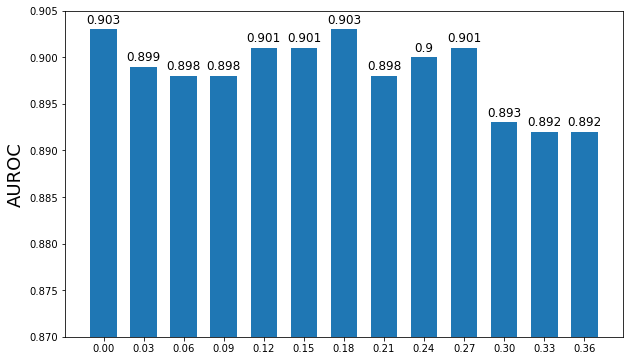

In [251]:
print('Validation results per threshold value')
thresholds_df_t036 = thresholds_df.loc[[i*0.03 for i in range(13)]]
create_fs_barplots(thresholds_df_t036, 0.02)

> Unfortunatly, there is no way to extract the number of selected features from grid search. Need to parse the printed text: "threshold=0.00, selected_features= 450
threshold=0.03, selected_features= 406..."

**In the paper - show results from threshold 0 to 0.36**

# Final model

## Perform feature selection process on the entire train dataset, using best parameters

In [252]:
best_k = 450
best_t = 0.18

In [253]:
X_train_raw, X_test_raw = train_dataset.data, test_dataset.data
y_train, y_test = train_dataset.y, test_dataset.y

# created corr matrix using feature_selection.create_corr_matrix(X_train_raw, y_train) 
corr_matrix_path = path / 'X_train_corr_mat_k450.csv'
X_train_corr_matrix = pd.read_csv(corr_matrix_path, index_col=0)
X_train_dist_mat = feature_selection.feature_corr_to_dist_matrix(X_train_corr_matrix)

fs_pipeline = Pipeline(steps=[('vectorize', CountVectorizer(lowercase=False, binary=True)),
                               ('k_best', SelectKBest(score_func=sklearn.feature_selection.chi2, k=best_k)),
                               ('cluster', feature_selection.SelectHierarchicalClustering(X_train_dist_mat, threshold=best_t)),
                               ('rf', RandomForestClassifier(random_state=0))])

fs_pipeline.fit(X_train_raw, y_train)

results = train_and_predict.predict_and_print_results(X_test_raw, y_test, fs_pipeline)

threshold=0.18, selected_features=250
false_positive: 21,total NHPs: 102
false_negative: 6,total HPs: 102
BAcc: 0.87
sensitivity: 0.94
specificity: 0.79
aupr_auc: 0.96
roc_auc: 0.95


In [254]:
y_train.value_counts()

1    428
0    213
Name: Label, dtype: int64

## Extract final features

In [255]:
all_pgfams = pd.array(fs_pipeline['vectorize'].get_feature_names())
k_best_pgfams = all_pgfams[fs_pipeline['k_best'].get_support()]
cluster_pgfams = k_best_pgfams[fs_pipeline['cluster'].get_support()]

In [256]:
len(all_pgfams)

393042

In [257]:
vectorizer = CountVectorizer(lowercase=False, binary=True, vocabulary=cluster_pgfams)
X_train_fs_clust = train_dataset.vectorize_data(vectorizer)

In [258]:
assert all(cluster_pgfams == vectorizer.get_feature_names())

In [259]:
assert all(cluster_pgfams == X_train_fs_clust.columns)

In [260]:
vectorizer = CountVectorizer(lowercase=False, binary=True, vocabulary=k_best_pgfams)
X_train_fs_k_best = train_dataset.vectorize_data(vectorizer)

In [261]:
chi2_vals, __ = sklearn.feature_selection.chi2(X_train_fs_k_best, y_train)
min(chi2_vals)

68.3802547338115

In [262]:
def get_hp_to_nhp_count(X, y, pgfam):
    return feature_importance.count_hp_vs_nhp(X[X[pgfam]==1].index, y)

hp_features = []
nhp_features = []

for pgfam in k_best_pgfams:
    hp, nhp = get_hp_to_nhp_count(X_train_fs_k_best, y_train, pgfam)
    if hp > nhp:
        hp_features.append(hp)
    else:
        nhp_features.append(nhp)
        
min(hp_features), min(nhp_features)

(139, 35)

## Final WSPC model
A random forest model, which includes the selected genes as features

In [263]:
WSPC, results = train_and_predict.train_and_predict(X_train_raw, y_train, X_test_raw, y_test, features=cluster_pgfams)

false_positive: 21,total NHPs: 102
false_negative: 6,total HPs: 102
BAcc: 0.87
sensitivity: 0.94
specificity: 0.79
aupr_auc: 0.96
roc_auc: 0.95


In [264]:
predictions, predictions_probs = train_and_predict.predict(X_test_raw, WSPC)

In [265]:
predict_df = pd.DataFrame({'predictions':predictions, 'predictions_probs':predictions_probs}, index=X_test_raw.index)
predict_df.head()

,predictions,predictions_probs
Genome ID,,
163603.4,1,0.62
648.157,1,0.98
565.15,1,0.93
29459.655,1,1.00
87883.284,1,0.99


In [266]:
path = Path('..\comp_analysis')
predict_df.to_csv(path/'wspc_test_preds.csv')

In [267]:
out_path = r'..\WSPC Model'
model_filename = 'WSPC_model'
util.save_model(out_path, model_filename, WSPC)

# Plot Results

In [269]:
def results_barplots(results, round_by=2):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.bar(*zip(*results.items()))
    ax.set_ylabel('Scores',  fontsize=18)
    ax.set_xticklabels(results.keys(), fontsize=14)
    ax.set_ylim([0.1, 1.05])
    add_bar_labels(ax, round_by)

    plt.show()  

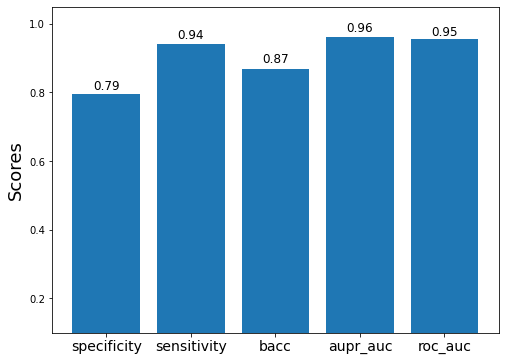

In [270]:
results_barplots(results)